In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [7]:
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

X_test = torch.Tensor( testset.data ) / 255.0# - 0.5
y_test = torch.Tensor( testset.targets ).long()
X_train = torch.Tensor( trainset.data ) / 255.0# - 0.5
y_train = torch.Tensor( trainset.targets ).long()

# train_dataset = TensorDataset(X_train, y_train)

train_data = DataLoader(trainset, batch_size=256, shuffle=True, drop_last=True)
train_data_iter = iter(train_data)

test_data = DataLoader(testset, batch_size=256, shuffle=True, drop_last=True)
test_data_iter = iter(test_data)

# Noise scheduling-- how fast do we want to add noise?

We want to arrive at an isotropic Gaussian distribution: one with $0$ mean and equal covariances.

In [8]:
def linear_schedule(timesteps, start=1e-4, end=.02):
    betas = torch.linspace(start, end, timesteps)
    return betas

def cosine_schedule(timesteps, s=0.008):
    def f(t):
        return torch.cos((t / timesteps + s) / (1 + s) * 0.5 * torch.pi) ** 2
    x = torch.linspace(0, timesteps, timesteps + 1)
    alphas_cumprod = f(x) / f(torch.tensor([0]))
    betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
    betas = torch.clip(betas, 0.0001, 0.999)
    return betas

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion(x_0, t, alphas_cumprod, device="cpu"):
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    # print()
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

In [48]:
# Define beta schedule
T = 300
beta_linear = linear_schedule(timesteps=T)
beta_cosine = cosine_schedule(timesteps=T)


# Pre-calculate different terms for closed form
alpha_linear = 1.0 - beta_linear
alphas_cumprod_linear = torch.cumprod(alpha_linear, axis=0)

alpha_cosine = 1.0 - beta_cosine
alphas_cumprod_cosine = torch.cumprod(alpha_cosine, axis=0)

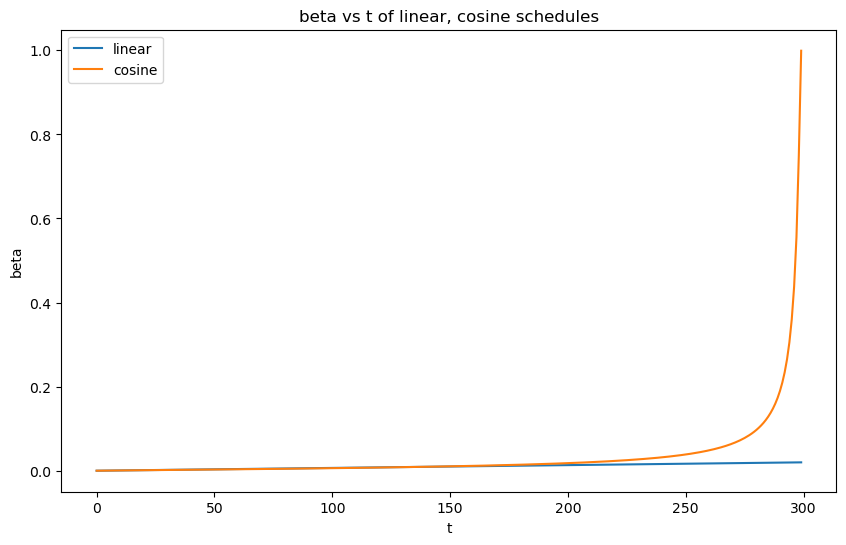

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(beta_linear, label="linear")
ax.plot(beta_cosine, label="cosine")

ax.set_title("beta vs t of linear, cosine schedules")
ax.set_xlabel("t")
ax.set_ylabel("beta")

ax.legend()

/tmp/ipykernel_21955/2354387054.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
/tmp/ipykernel_21955/2354387054.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


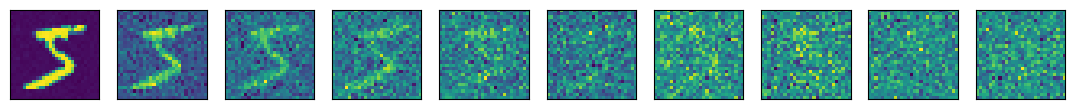

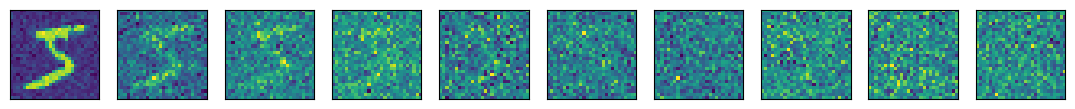

In [35]:
num_images = 10
stepsize = int(T/num_images)

image = X_train[0:1]

plt.figure(figsize=(15,15))
plt.axis('off')

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    # print(t)
    img, noise = forward_diffusion(image, t, alphas_cumprod_linear)
    # print(img.shape)
    # plt.imshow(X_train[0], cmap="Greys")
    plt.imshow(img[0].detach().numpy())
    plt.xticks([])
    plt.yticks([])


plt.figure(figsize=(15,15))
plt.axis('off')
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    # print(t)
    img, noise = forward_diffusion(image, t, alphas_cumprod_cosine)
    # print(img.shape)
    # plt.imshow(X_train[0], cmap="Greys")
    plt.imshow(img[0].detach().numpy())
    plt.xticks([])
    plt.yticks([])